In [1]:
# Mounting gdrive if working on gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from sklearn import metrics
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
project_home = "/content/gdrive/My Drive/USML/Clinical Trials"

In [4]:
# Load Data
records_data = pd.read_csv(os.path.join(project_home, "all_trials.csv"))
mesh_data = pd.read_csv(os.path.join(project_home, "MESH_Terms_v2.csv"))
punc = '!"#$%&\'()*+,./:;<=>?@[\\]^`{|}~'

In [5]:
records_data_eda = pd.read_csv(os.path.join(project_home, "all_trials.csv"))

In [6]:
records_data.shape

(345092, 14)

In [7]:
mesh_data.shape

(252051, 4)

In [8]:
# Process start_date of Alltrials to subset only 2017-2020 studies
from datetime import datetime
for i in range(records_data.shape[0]):
  if(type(records_data['start_date'][i]) != float):
    if(',' in records_data['start_date'][i]):
      records_data['start_date'][i] = datetime.strptime(records_data['start_date'][i],"%B %d, %Y").strftime("%Y")
    else:
      records_data['start_date'][i] = datetime.strptime(records_data['start_date'][i],"%B %Y").strftime("%Y")

records_data =  records_data[(records_data.start_date.isin(['2017','2018','2019','2020']))]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
# Process clinical records data
records_data = records_data[['id','title','brief_summary','detailed_description']] # Subset columns
records_data = records_data.replace(np.nan, '', regex=True) # Replace Null values with empty strings
records_data['article'] = records_data['title'].str.cat(records_data['brief_summary'], sep=" ").str.cat(records_data['detailed_description'], sep=" ") # Create Concatenated text using all data
records_data = records_data.drop(['title','brief_summary','detailed_description'], axis=1)
records_data['article'] = records_data['article'].str.lower()   ## lower case
records_data.article =  records_data.article.str.translate(str.maketrans('','',punc))   # Remove punctuations except '-', '_'
records_data.article =  records_data.article.str.strip()    # Remove whitespaces

In [10]:
# Process Mesh Data
mesh_data.Term =  mesh_data.Term.str.translate(str.maketrans('','',punc))
mesh_data.Term =  mesh_data.Term.str.strip()
mesh_data['Term'] = mesh_data['Term'].str.lower()

In [11]:
# Creating the mesh term vocabulary
mesh_vec = CountVectorizer(lowercase=True, token_pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+')
mesh_tdm = mesh_vec.fit_transform(mesh_data.Term)
mesh_vocab = mesh_vec.get_feature_names()
print(len(set(mesh_vocab))) # 78,224

78224


In [12]:
# Creating the records vocablary - TF-IDF
records_tfidf_vec = TfidfVectorizer(lowercase=True, token_pattern = '[a-zA-Z0-9$&+,:;=?@#|<>.^*()%!-]+', min_df = 0.01, max_df = 0.25) # atleast appearing in 1% records
records_tfidf = records_tfidf_vec.fit_transform(records_data['article'])
records_tfidf_vocab = records_tfidf_vec.get_feature_names()
print(len(set(records_tfidf_vocab))) #2186

2186


In [13]:
# Finding the common vocabulary - TF-IDF
com_mesh_rec_tfidf = set(mesh_vocab).intersection(set(records_tfidf_vocab))
print(len(com_mesh_rec_tfidf)) #1601

1601


In [14]:
# Trimming TF-IDF matrix using common vocabulary
records_tfidf_df = pd.DataFrame(records_tfidf.todense(), columns= records_tfidf_vocab)
records_tfidf_df = records_tfidf_df[com_mesh_rec_tfidf]
records_tfidf_df = records_tfidf_df.loc[(records_tfidf_df.sum(axis=1) != 0.0), (records_tfidf_df.sum(axis=0) != 0.0)] # remove rows and columns with sum 0

In [15]:
records_tfidf_df = np.transpose(records_tfidf_df)
records_tfidf_df.shape   #  (1601, 101351)

# Without Max_df= (101351, 1642)
# With Max_df = 0.25 = (101351, 1601)
# With Max_df = 0.2 = (101350, 1581)

(1601, 101351)

In [16]:
#Matrix by code
# columnWithoutMaxdf = list(records_tfidf_df.columns)
# columnWithoutMaxdf  --- 1642
# columnWithMaxdf = list(records_tfidf_df.columns)

# lost_words = set(columnWithoutMaxdf) - set(columnWithMaxdf)
# lost_words

In [17]:
# # If importing the pickle file
# records_tfidf_df.to_pickle(os.path.join(project_home, "mesh_matrix_tfidf_v3.pkl"))
# tfidfPickle = pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/Datasets/Clinical Trials/mesh_matrix_tfidf_v3.pkl')

# ***Exploratory Data Analysis***

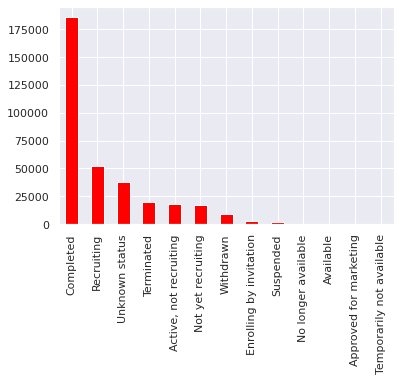

In [18]:
records_data_eda['overall_status'].value_counts().plot.bar(color='red')

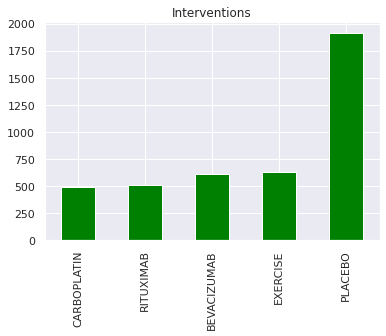

In [19]:
interventional_studies = records_data_eda[records_data_eda['study_type']=='Interventional']
top_interventions = interventional_studies['intervention'].value_counts().sort_values(ascending=True)[-5:]
top_interventions.plot.bar(title='Interventions',color='green')

In [20]:
labels = records_data_eda['study_type'].value_counts().index
values = records_data_eda['study_type'].value_counts().values
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent')])
fig.show()

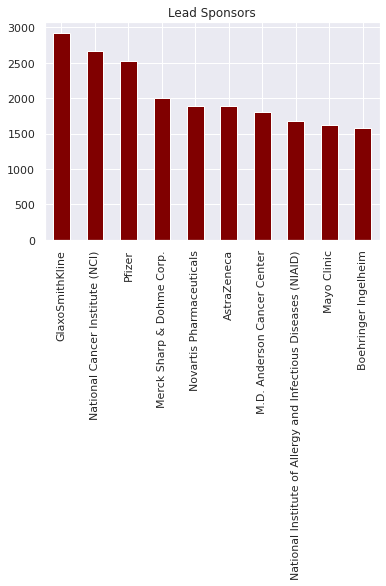

In [21]:
lead_sponsors = interventional_studies['sponsors'].value_counts().sort_values(ascending=False)[:10]
lead_sponsors.plot.bar(title='Lead Sponsors', color = 'maroon')

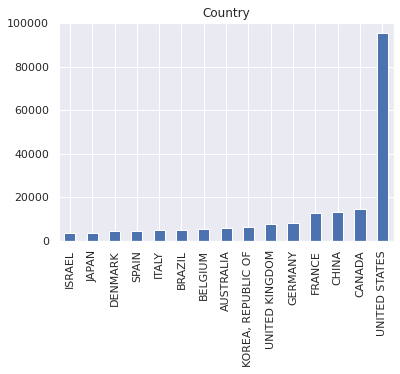

In [22]:
# Top 10 Countries
countries = interventional_studies[interventional_studies['location_countries']!='']
country = countries['location_countries'].value_counts().sort_values()[-15:]
country.plot.bar(title='Country')

#PCA & K means Clustering


In [23]:
# Allowing components that explain 95% variance in PCA
pca = PCA(n_components=0.95, random_state=42)
records_tfidf_df_reduced = pca.fit_transform(records_tfidf_df)
records_tfidf_df_reduced.shape

(1601, 1255)

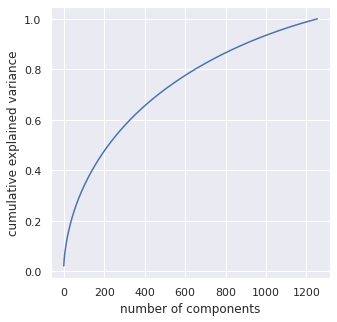

In [24]:
# Plotting cumulative sum of variance explained to choose best n_components
pca = PCA(random_state = 42).fit(records_tfidf_df_reduced)
plt.figure(figsize=(5,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [25]:
# PCA on best n_component obtained by above
pca = PCA(n_components = 800, random_state=42)
records_tfidf_df_reduced= pca.fit_transform(records_tfidf_df)
records_tfidf_df_reduced.shape

(1601, 800)

In [30]:
# run kmeans with many different k
distortions, SilhouetteCoefficient, CHIndex, clusterCenters, clusterLabels= [], [], [], [], []
K = range(2,50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(records_tfidf_df_reduced)
    k_means.fit(records_tfidf_df_reduced)
    res = k_means.predict(records_tfidf_df_reduced)
    silCoeff = silhouette_score(records_tfidf_df_reduced, res)
    calHarScore = calinski_harabasz_score(records_tfidf_df_reduced, res)
    print ("{} cluster : Silhouette Coefficient\t{}\tCH Index\t{}".format(k, silCoeff, calHarScore))
    SilhouetteCoefficient.append(silCoeff)
    CHIndex.append(calHarScore)
    clusterCenters.append(k_means.cluster_centers_)
    clusterLabels.append(k_means.labels_)
    distortions.append(sum(np.min(cdist(records_tfidf_df_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / records_tfidf_df.shape[0])

2 cluster : Silhouette Coefficient	0.3762695189175803	CH Index	26.493790287943884
3 cluster : Silhouette Coefficient	0.5441175594015457	CH Index	12.890491756264794
4 cluster : Silhouette Coefficient	0.3099554283864894	CH Index	11.658800866905976
5 cluster : Silhouette Coefficient	0.48787488672945234	CH Index	11.831104532162318
6 cluster : Silhouette Coefficient	0.4897551295092527	CH Index	10.540843437974045
7 cluster : Silhouette Coefficient	0.4880108810717345	CH Index	9.628392489282078
8 cluster : Silhouette Coefficient	0.2579298390708911	CH Index	10.620090210263836
9 cluster : Silhouette Coefficient	0.25758777933837157	CH Index	9.710229280452277
10 cluster : Silhouette Coefficient	0.2577350724569466	CH Index	9.381678564958529
11 cluster : Silhouette Coefficient	0.30802672344800414	CH Index	9.138340694777684
12 cluster : Silhouette Coefficient	0.30839104525084926	CH Index	8.956854304959766
13 cluster : Silhouette Coefficient	0.30334079351862403	CH Index	8.808184627306009
14 cluster : 

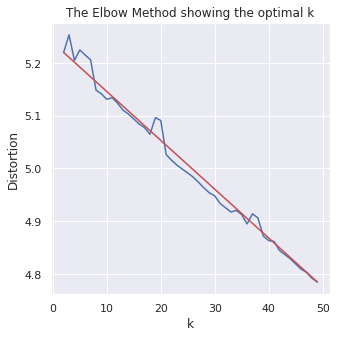

In [43]:
# Plot Elbow to check best k
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

plt.figure(figsize=(5,5))
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

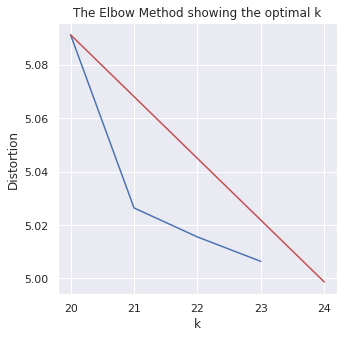

In [44]:
# Plot Elbow to check best k
X_line = [K[18], K[22]]
Y_line = [distortions[18], distortions[22]]

plt.figure(figsize=(5,5))
plt.plot(K[18:22], distortions[18:22], 'b')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [45]:
# K means on best k obtained above
k = 21
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(records_tfidf_df_reduced)
y_pred

array([12,  2,  2, ...,  2,  2,  2], dtype=int32)

In [46]:
y_pred.shape

(1601,)

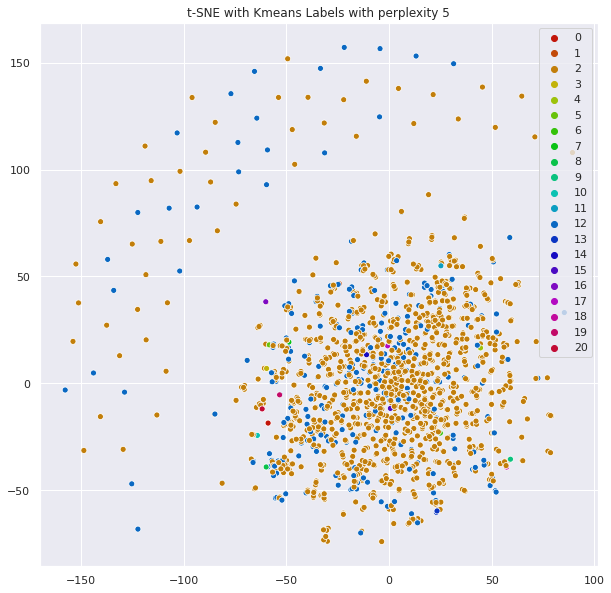

In [47]:
tsne = TSNE(perplexity = 5, random_state=42)
records_tfidf_df_embedded = tsne.fit_transform(records_tfidf_df_reduced)
# t-SNE with Kmeans Labels
sns.set(rc={'figure.figsize':(10,10)})
palette = sns.hls_palette(21, l=.4, s=.9)
sns.scatterplot(records_tfidf_df_embedded[:,0], records_tfidf_df_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels with perplexity 5')
plt.show()

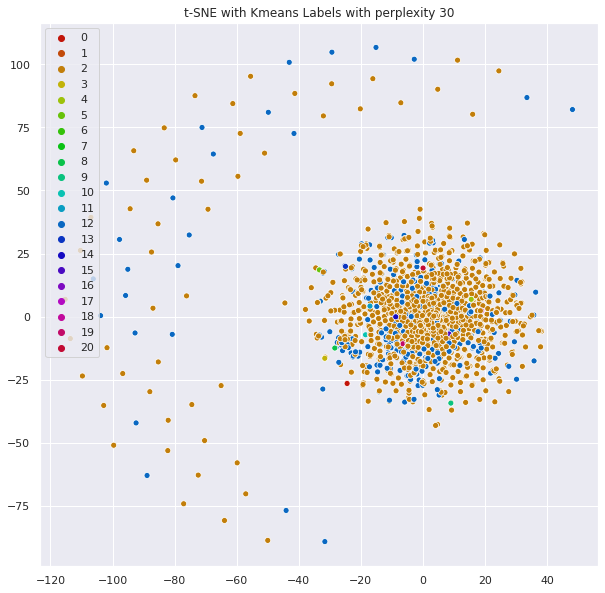

In [48]:
tsne = TSNE(perplexity=30, random_state=42)
records_tfidf_df_embedded = tsne.fit_transform(records_tfidf_df_reduced)
# t-SNE with Kmeans Labels
sns.set(rc={'figure.figsize':(10,10)})
palette = sns.hls_palette(21, l=.4, s=.9)
sns.scatterplot(records_tfidf_df_embedded[:,0], records_tfidf_df_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels with perplexity 30')
plt.show()

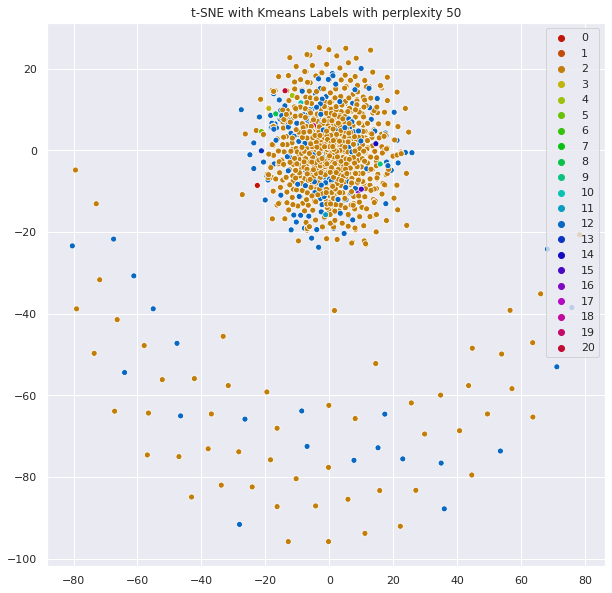

In [49]:
tsne = TSNE(perplexity=50, random_state=42)
records_tfidf_df_embedded = tsne.fit_transform(records_tfidf_df_reduced)
# t-SNE with Kmeans Labels
sns.set(rc={'figure.figsize':(10,10)})
palette = sns.hls_palette(21, l=.4, s=.9)
sns.scatterplot(records_tfidf_df_embedded[:,0], records_tfidf_df_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels with perplexity 50')
plt.show()

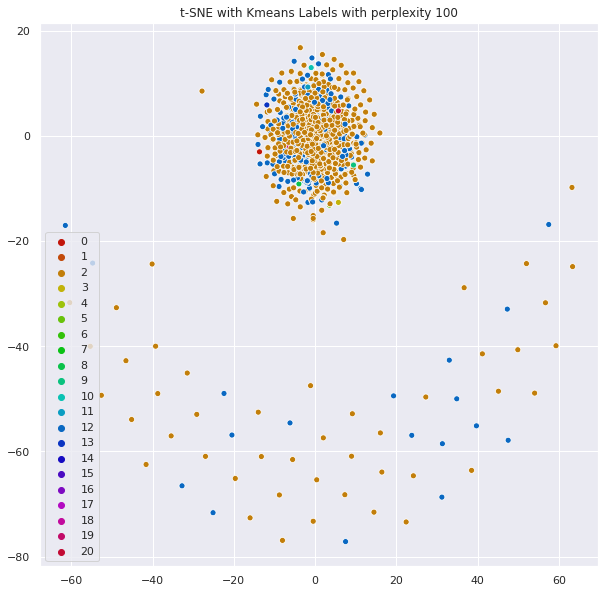

In [50]:
tsne = TSNE(perplexity=100, random_state=42)
records_tfidf_df_embedded = tsne.fit_transform(records_tfidf_df_reduced)
# t-SNE with Kmeans Labels
sns.set(rc={'figure.figsize':(10,10)})
palette = sns.hls_palette(21, l=.4, s=.9)
# palette = sns.color_palette("hls",21)
sns.scatterplot(records_tfidf_df_embedded[:,0], records_tfidf_df_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels with perplexity 100')
plt.show()

#PCA and Gaussian Mixture Model

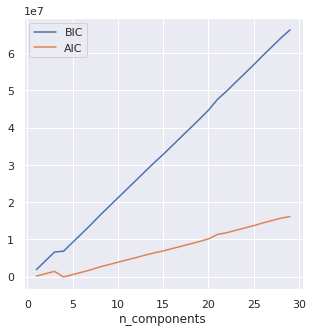

In [51]:
# Checking best n_components for GMM using plot for AIC and BIC
n_components = np.arange(1, 30)
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(records_tfidf_df_reduced)
          for n in n_components]
plt.figure(figsize=(5,5))
plt.plot(n_components, [m.bic(records_tfidf_df_reduced) for m in models], label='BIC')
plt.plot(n_components, [m.aic(records_tfidf_df_reduced) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [52]:
# GMM on best n_component obtained above
cluster_gmm = []
gmm = GaussianMixture(n_components = 4, random_state=42)
gmm.fit(records_tfidf_df_reduced)
cluster_gmm.append(gmm.predict(records_tfidf_df_reduced))
y_pred_GMM = gmm.fit_predict(records_tfidf_df_reduced)

In [53]:
y_pred_GMM.shape

(1601,)

In [54]:
silCoeffGMM = silhouette_score(records_tfidf_df_reduced, y_pred_GMM)
calHarScoreGMM = calinski_harabasz_score(records_tfidf_df_reduced, y_pred_GMM)
print ("{} cluster : Silhouette Coefficient\t{}\tCH Index\t{}".format(k, silCoeffGMM, calHarScoreGMM))

21 cluster : Silhouette Coefficient	0.3099554283864894	CH Index	11.658800866905976


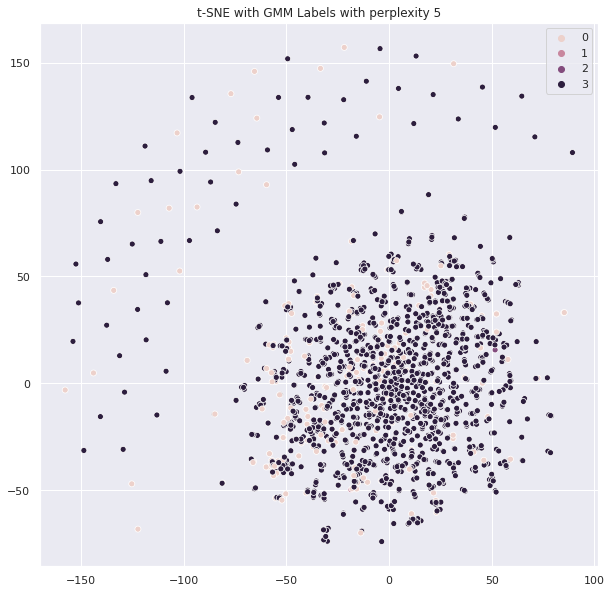

In [55]:
# t-SNE with GMM Labels
tsne = TSNE(perplexity = 5, random_state=42)
records_tfidf_df_embedded = tsne.fit_transform(records_tfidf_df_reduced)
sns.set(rc={'figure.figsize':(10,10)})
palette = sns.hls_palette(4, l=.4, s=.9)
sns.scatterplot(records_tfidf_df_embedded[:,0], records_tfidf_df_embedded[:,1], hue= y_pred_GMM, legend='full')
plt.title('t-SNE with GMM Labels with perplexity 5')
plt.show()

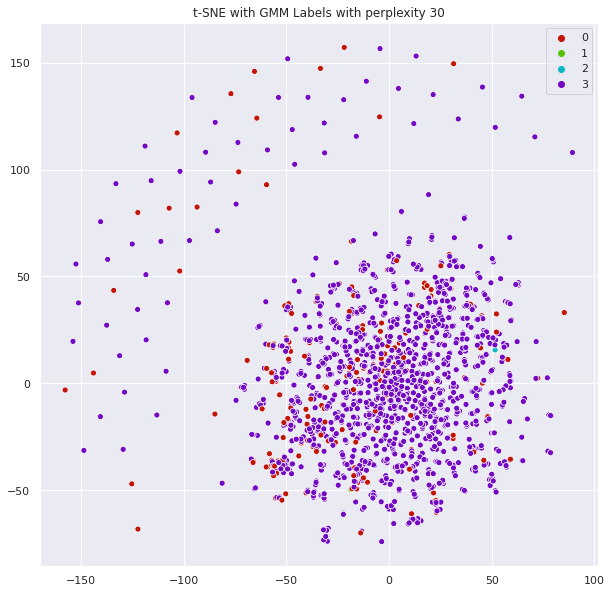

In [57]:
# t-SNE with GMM Labels
tsne = TSNE(perplexity = 5, random_state=42)
records_tfidf_df_embedded = tsne.fit_transform(records_tfidf_df_reduced)
sns.set(rc={'figure.figsize':(10,10)})
palette = sns.hls_palette(4, l=.4, s=.9)
sns.scatterplot(records_tfidf_df_embedded[:,0], records_tfidf_df_embedded[:,1], hue= y_pred_GMM, legend='full', palette=palette)
plt.title('t-SNE with GMM Labels with perplexity 30')
plt.show()

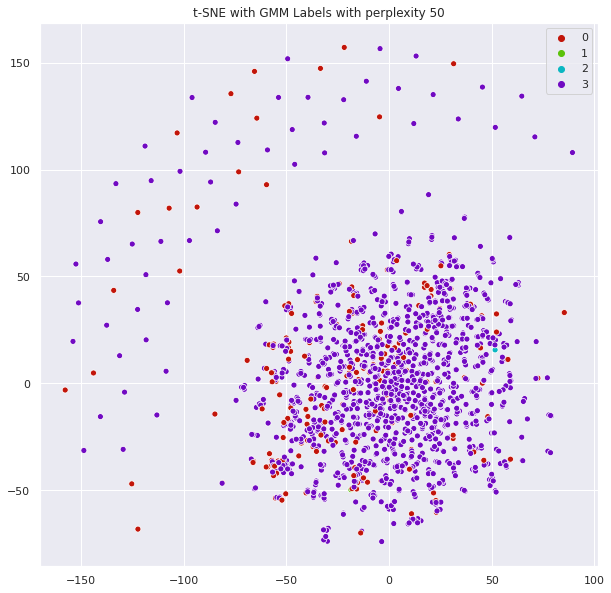

In [58]:
# t-SNE with GMM Labels
tsne = TSNE(perplexity = 5, random_state=42)
records_tfidf_df_embedded = tsne.fit_transform(records_tfidf_df_reduced)
sns.set(rc={'figure.figsize':(10,10)})
palette = sns.hls_palette(4, l=.4, s=.9)
sns.scatterplot(records_tfidf_df_embedded[:,0], records_tfidf_df_embedded[:,1], hue= y_pred_GMM, legend='full', palette=palette)
plt.title('t-SNE with GMM Labels with perplexity 50')
plt.show()

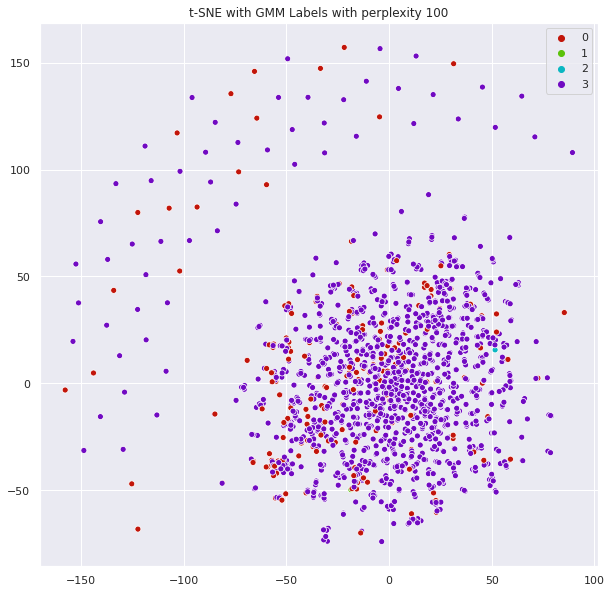

In [59]:
# t-SNE with GMM Labels
tsne = TSNE(perplexity = 5, random_state=42)
records_tfidf_df_embedded = tsne.fit_transform(records_tfidf_df_reduced)
sns.set(rc={'figure.figsize':(10,10)})
palette = sns.hls_palette(4, l=.4, s=.9)
sns.scatterplot(records_tfidf_df_embedded[:,0], records_tfidf_df_embedded[:,1], hue= y_pred_GMM, legend='full', palette=palette)
plt.title('t-SNE with GMM Labels with perplexity 100')
plt.show()